TF-IDF Implementation

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

We load the GDPR json and flatten the structure of the json to get a dataframe

In [18]:
with open('../gdpr_articles_baseline.json', 'r', encoding='utf-8') as f:
    gdpr_data = json.load(f)

# Flatten the structure
flattened = []
for article in gdpr_data:
    for section in article['sections']:
        for sec_num, sec_text in section.items():
            flattened.append({
                "article_number": article['article_number'],
                "article_title": article['article_title'],
                "section_number": sec_num,
                "section_text": sec_text
            })

gdpr_df = pd.DataFrame(flattened)
gdpr_df.head()

,article_number,article_title,section_number,section_text
0,1,Subject-matter and objectives,1.,This Regulation lays down rules relating to th...
1,1,Subject-matter and objectives,2.,This Regulation protects fundamental rights an...
2,1,Subject-matter and objectives,3.,The free movement of personal data within the ...
3,2,Material scope,1.,This Regulation applies to the processing of p...
4,2,Material scope,2.,This Regulation does not apply to the processi...


We have only focused on GDPR articles 5-7

In [19]:
# Filtering only articles 5-7 
#gdpr_df = gdpr_df.loc[gdpr_df['article_number'].isin([5, 6, 7])]
gdpr_df

,article_number,article_title,section_number,section_text
0,1,Subject-matter and objectives,1.,This Regulation lays down rules relating to th...
1,1,Subject-matter and objectives,2.,This Regulation protects fundamental rights an...
2,1,Subject-matter and objectives,3.,The free movement of personal data within the ...
3,2,Material scope,1.,This Regulation applies to the processing of p...
4,2,Material scope,2.,This Regulation does not apply to the processi...
...,...,...,...,...
761,97,Commission reports,6.,In carrying out the evaluations and reviews re...
762,97,Commission reports,7.,"The Commission shall, if necessary, submit app..."
763,98,Review of other Union legal acts on data prote...,1.,"1\nThe Commission shall, if appropriate, submi..."
764,99,Entry into force and application,1.,This Regulation shall enter into force on the ...


Load the privacy policy as dataframe

In [20]:
with open("../ikea_privacy_policy.json", encoding="utf-8") as f:
    ikea_data = json.load(f)

ikea_df = pd.DataFrame(ikea_data)
ikea_df

,section_title,section_text
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...
1,2. What data is being processed and from which...,We process the data that we receive from you i...
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...
4,5. Who will be receiving your data?,Your data will be passed on to the following r...
5,6. Are you obliged to provide data?,You will need to give us your data for us to b...
6,7. Is there automated decision-making includin...,We will not use automated decision-making acco...
7,8. Your rights in processing your personal data,You may (i) demand disclosure on whether and w...


We define a clean_text function to preprocess textual data in the section_text column of the iprivacy policy DataFrame:

- Convert to lowercase
- Remove special characters and numbers
- Tokenize the text into individual words.
- Remove stop words using ENGLISH_STOP_WORDS
- Combines the cleaned words back into a single string.
The cleaned result is stored in a new column called clean_text.

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS]
    return " ".join(tokens)

ikea_df["clean_text"] = ikea_df["section_text"].apply(clean_text)
ikea_df

,section_title,section_text,clean_text
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...,party responsible processing data controller i...
1,2. What data is being processed and from which...,We process the data that we receive from you i...,process data receive business relationship inc...
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...,process data specific purposes specific durati...
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...,grounds consent art para lit gdpr process pers...
4,5. Who will be receiving your data?,Your data will be passed on to the following r...,data passed following recipients contractors p...
5,6. Are you obliged to provide data?,You will need to give us your data for us to b...,need data able fulfil contractual obligations ...
6,7. Is there automated decision-making includin...,We will not use automated decision-making acco...,use automated decisionmaking according art gdp...
7,8. Your rights in processing your personal data,You may (i) demand disclosure on whether and w...,demand disclosure personal information stored ...


For GDPR articles, we convert the text to lower case, remove whitespaces and replace whitespace characters with a single space

In [22]:
def clean_text(text):
    return re.sub(r'\s+', ' ', text.lower().strip())

gdpr_df['cleaned_section'] = gdpr_df['section_text'].apply(clean_text)
gdpr_df.head()

,article_number,article_title,section_number,section_text,cleaned_section
0,1,Subject-matter and objectives,1.,This Regulation lays down rules relating to th...,this regulation lays down rules relating to th...
1,1,Subject-matter and objectives,2.,This Regulation protects fundamental rights an...,this regulation protects fundamental rights an...
2,1,Subject-matter and objectives,3.,The free movement of personal data within the ...,the free movement of personal data within the ...
3,2,Material scope,1.,This Regulation applies to the processing of p...,this regulation applies to the processing of p...
4,2,Material scope,2.,This Regulation does not apply to the processi...,this regulation does not apply to the processi...


We merge the cleaned privacy policy and GDPR text, vectorize the joint corpus and then get their seprate TF-IDF matrix

In [23]:
combined_corpus = pd.concat([ikea_df["clean_text"], gdpr_df["cleaned_section"]])
vectorizer = TfidfVectorizer()
combined_tfidf = vectorizer.fit_transform(combined_corpus)

# Split the combined TF-IDF matrix
ikea_tfidf = combined_tfidf[:len(ikea_df)]
gdpr_tfidf = combined_tfidf[len(ikea_df):]

We then calculate the cosine similarity between each privacy policy section and each GDPR section based on their TF-IDF vectors.

In [24]:
similarity = cosine_similarity(ikea_tfidf, gdpr_tfidf)
similarity_df = pd.DataFrame(
    similarity,
    index=ikea_df["section_title"],
    columns=[f"Art. {a}-{s}" for a, s in zip(gdpr_df["article_number"], gdpr_df["section_number"])]
)

similarity_df

,Art. 1-1.,Art. 1-2.,Art. 1-3.,Art. 2-1.,Art. 2-2.,Art. 2-3.,Art. 2-4.,Art. 2-5.,Art. 2-6.,Art. 2-7.,...,Art. 97-1.,Art. 97-2.,Art. 97-3.,Art. 97-4.,Art. 97-5.,Art. 97-6.,Art. 97-7.,Art. 98-1.,Art. 99-1.,Art. 99-2.
section_title,,,,,,,,,,,,,,,,,,,,,
1. Who is the responsible controller for the data processing and whom you may contact?,0.028249,0.013247,0.025954,0.023310,0.010363,0.000000,0.0,0.006421,0.000000,0.022368,...,0.015945,0.005695,0.008021,0.0,0.000000,0.000000,0.000000,0.035670,0.016637,0.000000
2. What data is being processed and from which sources do these stem from?,0.045683,0.031111,0.041972,0.028745,0.014303,0.000000,0.0,0.012776,0.000000,0.045264,...,0.000000,0.013374,0.018837,0.0,0.000000,0.000000,0.000000,0.032046,0.020499,0.000000
3. For which purpose and for how long is the data being processed?,0.064284,0.046437,0.059063,0.037992,0.043732,0.000000,0.0,0.000000,0.051491,0.049438,...,0.000000,0.013245,0.018656,0.0,0.000000,0.000000,0.000000,0.056401,0.000000,0.000000
4. On which legal basis is personal data being processed?,0.068249,0.026586,0.063839,0.041731,0.029887,0.000000,0.0,0.007901,0.024861,0.057914,...,0.020412,0.019687,0.026713,0.0,0.020288,0.001036,0.013564,0.152257,0.008095,0.002403
5. Who will be receiving your data?,0.036280,0.024708,0.033334,0.022828,0.059621,0.033016,0.0,0.000000,0.069674,0.036357,...,0.006261,0.018543,0.026119,0.0,0.028759,0.011051,0.014775,0.029202,0.028693,0.000000
6. Are you obliged to provide data?,0.078200,0.020804,0.071848,0.019222,0.011123,0.000000,0.0,0.000000,0.007243,0.018445,...,0.000000,0.008943,0.012597,0.0,0.000000,0.000000,0.016587,0.044044,0.000000,0.000000
7. Is there automated decision-making including profiling?,0.000000,0.000000,0.000000,0.064099,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.052895,0.074504,0.0,0.000000,0.000000,0.000000,0.139913,0.000000,0.000000
8. Your rights in processing your personal data,0.089707,0.076207,0.082421,0.054811,0.028855,0.000000,0.0,0.029402,0.000000,0.052596,...,0.000000,0.022553,0.031767,0.0,0.068263,0.000000,0.017125,0.050667,0.000000,0.000000


In [25]:
similarity_df

,Art. 1-1.,Art. 1-2.,Art. 1-3.,Art. 2-1.,Art. 2-2.,Art. 2-3.,Art. 2-4.,Art. 2-5.,Art. 2-6.,Art. 2-7.,...,Art. 97-1.,Art. 97-2.,Art. 97-3.,Art. 97-4.,Art. 97-5.,Art. 97-6.,Art. 97-7.,Art. 98-1.,Art. 99-1.,Art. 99-2.
section_title,,,,,,,,,,,,,,,,,,,,,
1. Who is the responsible controller for the data processing and whom you may contact?,0.028249,0.013247,0.025954,0.023310,0.010363,0.000000,0.0,0.006421,0.000000,0.022368,...,0.015945,0.005695,0.008021,0.0,0.000000,0.000000,0.000000,0.035670,0.016637,0.000000
2. What data is being processed and from which sources do these stem from?,0.045683,0.031111,0.041972,0.028745,0.014303,0.000000,0.0,0.012776,0.000000,0.045264,...,0.000000,0.013374,0.018837,0.0,0.000000,0.000000,0.000000,0.032046,0.020499,0.000000
3. For which purpose and for how long is the data being processed?,0.064284,0.046437,0.059063,0.037992,0.043732,0.000000,0.0,0.000000,0.051491,0.049438,...,0.000000,0.013245,0.018656,0.0,0.000000,0.000000,0.000000,0.056401,0.000000,0.000000
4. On which legal basis is personal data being processed?,0.068249,0.026586,0.063839,0.041731,0.029887,0.000000,0.0,0.007901,0.024861,0.057914,...,0.020412,0.019687,0.026713,0.0,0.020288,0.001036,0.013564,0.152257,0.008095,0.002403
5. Who will be receiving your data?,0.036280,0.024708,0.033334,0.022828,0.059621,0.033016,0.0,0.000000,0.069674,0.036357,...,0.006261,0.018543,0.026119,0.0,0.028759,0.011051,0.014775,0.029202,0.028693,0.000000
6. Are you obliged to provide data?,0.078200,0.020804,0.071848,0.019222,0.011123,0.000000,0.0,0.000000,0.007243,0.018445,...,0.000000,0.008943,0.012597,0.0,0.000000,0.000000,0.016587,0.044044,0.000000,0.000000
7. Is there automated decision-making including profiling?,0.000000,0.000000,0.000000,0.064099,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.052895,0.074504,0.0,0.000000,0.000000,0.000000,0.139913,0.000000,0.000000
8. Your rights in processing your personal data,0.089707,0.076207,0.082421,0.054811,0.028855,0.000000,0.0,0.029402,0.000000,0.052596,...,0.000000,0.022553,0.031767,0.0,0.068263,0.000000,0.017125,0.050667,0.000000,0.000000


In [26]:
ikea_df = ikea_df.reset_index(drop=True)
similarity_df = similarity_df.reset_index(drop=True)

We finally get the most similar matches from the GDPR law for the privacy poicy sections

In [27]:
ikea_df["best_match_gdpr_section"] = similarity_df.idxmax(axis=1)
ikea_df["similarity_score"] = similarity_df.max(axis=1)
ikea_df.head()

,section_title,section_text,clean_text,best_match_gdpr_section,similarity_score
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...,party responsible processing data controller i...,Art. 87-1.,0.111103
1,2. What data is being processed and from which...,We process the data that we receive from you i...,process data receive business relationship inc...,Art. 33-4.,0.182006
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...,process data specific purposes specific durati...,Art. 15-2.,0.317758
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...,grounds consent art para lit gdpr process pers...,Art. 29-1.,0.191869
4,5. Who will be receiving your data?,Your data will be passed on to the following r...,data passed following recipients contractors p...,Art. 23-11.,0.224797


In [34]:
ikea_df["section_index"] = ikea_df['section_title'].str.extract(r'^(\d+)\.')
ikea_df["article_number"] = ikea_df["best_match_gdpr_section"].str.extract(r'Art\.\s*(\d+)').astype(int)
ikea_df

,section_title,section_text,clean_text,best_match_gdpr_section,similarity_score,section_index,article_number
0,1. Who is the responsible controller for the d...,The party responsible for processing data (“co...,party responsible processing data controller i...,Art. 87-1.,0.111103,1,87
1,2. What data is being processed and from which...,We process the data that we receive from you i...,process data receive business relationship inc...,Art. 33-4.,0.182006,2,33
2,3. For which purpose and for how long is the d...,We process your data for specific purposes an...,process data specific purposes specific durati...,Art. 15-2.,0.317758,3,15
3,4. On which legal basis is personal data being...,4.1 On grounds of consent – Art 6 para 1 lit a...,grounds consent art para lit gdpr process pers...,Art. 29-1.,0.191869,4,29
4,5. Who will be receiving your data?,Your data will be passed on to the following r...,data passed following recipients contractors p...,Art. 23-11.,0.224797,5,23
5,6. Are you obliged to provide data?,You will need to give us your data for us to b...,need data able fulfil contractual obligations ...,Art. 37-9.,0.118762,6,37
6,7. Is there automated decision-making includin...,We will not use automated decision-making acco...,use automated decisionmaking according art gdp...,Art. 31-1.,0.175568,7,31
7,8. Your rights in processing your personal data,You may (i) demand disclosure on whether and w...,demand disclosure personal information stored ...,Art. 15-6.,0.172856,8,15


In [35]:
report = []
article_lookup = dict(zip(gdpr_df["article_number"], gdpr_df["article_title"]))
for idx, row in ikea_df.iterrows():
    
    section_title = row["section_title"]
    section_index = row["section_index"]
    article_number = row["article_number"]
    article_title = article_lookup.get(article_number, "Unknown Article")

    top_matches = [{
        "article": article_number,
        "title": article_title,
        "similarity": float(row["similarity_score"])
    }]

    # Append the structured dictionary to report
    report.append({
        "section_index": section_index,
        "section_title": section_title,
        "top_matches": top_matches
    })
print(json.dumps(report, indent=2, ensure_ascii=False))
with open("../results/ikea_tfidf.json", "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

[
  {
    "section_index": "1",
    "section_title": "1. Who is the responsible controller for the data processing and whom you may contact?",
    "top_matches": [
      {
        "article": 87,
        "title": "Processing of the national identification number",
        "similarity": 0.11110349777629627
      }
    ]
  },
  {
    "section_index": "2",
    "section_title": "2. What data is being processed and from which sources do these stem from?",
    "top_matches": [
      {
        "article": 33,
        "title": "Notification of a personal data breach to the supervisory authority",
        "similarity": 0.18200592646270553
      }
    ]
  },
  {
    "section_index": "3",
    "section_title": "3. For which purpose and for how long is the data being processed?",
    "top_matches": [
      {
        "article": 15,
        "title": "Right of access by the data subject",
        "similarity": 0.31775816918252037
      }
    ]
  },
  {
    "section_index": "4",
    "section_title": "4. 

In [32]:
print(type(gdpr_df["article_number"].iloc[0]))  # likely int or str
print(type(ikea_df["article_number"].iloc[0]))

<class 'numpy.int64'>
<class 'str'>


In [31]:
article_lookup

{1: 'Subject-matter and objectives',
 2: 'Material scope',
 3: 'Territorial scope',
 4: 'Definitions',
 5: 'Principles relating to processing of personal data',
 6: 'Lawfulness of processing',
 7: 'Conditions for consent',
 8: "Conditions applicable to child's consent in relation to information society services",
 9: 'Processing of special categories of personal data',
 10: 'Processing of personal data relating to criminal convictions and offences',
 11: 'Processing which does not require identification',
 12: 'Transparent information, communication and modalities for the exercise of the rights of the data subject',
 13: 'Information to be provided where personal data are collected from the data subject',
 14: 'Information to be provided where personal data have not been obtained from the data subject',
 15: 'Right of access by the data subject',
 16: 'Right to rectification',
 17: 'Right to erasure (‘right to be forgotten’)',
 18: 'Right to restriction of processing',
 19: 'Notificati

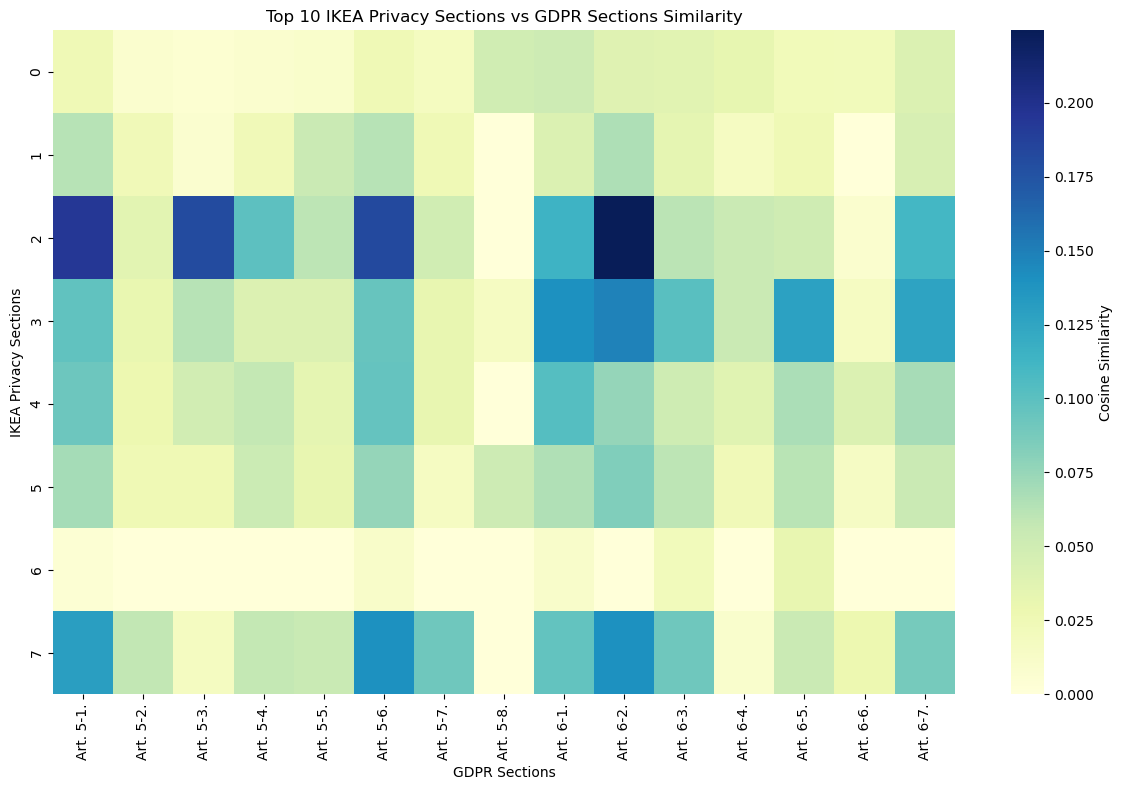

In [12]:
# Similarity matrix for top 10 IKEA sections
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_df.iloc[:10, :15], cmap="YlGnBu", cbar_kws={'label': 'Cosine Similarity'})
plt.title("Top 10 IKEA Privacy Sections vs GDPR Sections Similarity")
plt.xlabel("GDPR Sections")
plt.ylabel("IKEA Privacy Sections")
plt.tight_layout()
plt.show()